# Survival Analysis on Titanic Disaster

An analysis regarding following questions:
1. Did female and children have significant higher survival rates?
2. Were people with families more likely to survive than the ones were alone on the ship? 
3. Were the richer people (depending on the fare paid and their Pclass level) more likely to survive ?

The original data is downloaded from [Titanic from Kaggle](https://www.kaggle.com/c/titanic/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('titanic-data.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## ------Cleaning the data

1. Remove duplicate rows 
2. Handle all missing values
3. Group the numerical data(age, fare) as needed

In [3]:
# checking duplicate rows
print("The data set's size is:{}".format(df.shape))
print("After droping duplicates, the data set has changed to: {}".format(df.drop_duplicates().shape))

The data set's size is:(891, 12)
After droping duplicates, the data set has changed to: (891, 12)


In [4]:
# No duplicates found so check the missing values per column (True = 1, False = 0)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#checking the distribution of Embarked data 
df.groupby('Embarked').count()[['Survived']]

,Survived
Embarked,
C,168
Q,77
S,644


According to above information, there are _177_ missing values in the 'Age' column, _687_ missing values in the 'Cabin' column and _2_ missing values in the 'Embarked' column.

Below are how I deal with them:

1. For 'Age' data, I will assue the missing values are distributed similarly as the available data so __mean__ value will be a good approach for 'Nan'.

2. For 'Cabin' data, considering most of data (77.1% of total) is missing and it is really hard to estimate them without big bias. Plus the Pclass column could provide similar information--- the cabin location (represented by level 1 to 3) for our later analysis. I think it's reasonable to drop the whole 'Cabin' column here.

3. For 'Embarked' data, 'S' seemed to be a good estimate for the two missing values based on the what we knew.

In [6]:
# obtain the statistics of known age data
df_age_known = df[df['Age'].notnull()]
df_age_known['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [7]:
# replace the missing values with assumptions and store them in new dfs
df_age_nonull = df[['Age']].fillna(30)
df_embarked_nonull = df[['Embarked']].fillna('S')

# drop the columns with missing values 
df_temp = df.drop(['Age', 'Cabin', 'Embarked'], axis = 1)
df_no_null = pd.concat([df_temp, df_age_nonull, df_embarked_nonull], axis = 1)

In [8]:
# checking the 'Fare' column data statistics 
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [9]:
# Group age information
df_age_series = pd.cut(df_no_null['Age'], bins = [0, 12, 19, 60, 80], labels = ['Children', 'Teenager', 'Adults', 'Seniors'])
df_age_series.rename('Age Group', inplace = True)
df_tmp_age = pd.concat([df_no_null, df_age_series], axis = 1)

# Group fare information
df_fare_series = pd.cut(df_no_null['Fare'], bins = [0, 8, 15, 31, 513], labels = ['0 to 8', '08 to 15', '15 to 31', 'over 31'])
df_fare_series.rename('Fare Group', inplace = True)
df_tmp_age_fare = pd.concat([df_tmp_age, df_fare_series], axis = 1)

# Select the data we need
df_select = df_tmp_age_fare.drop(['PassengerId', 'Name', 'Ticket', 'Age', 'Fare'], axis = 1)
df_select.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age Group,Fare Group
0,0,3,male,1,0,S,Adults,0 to 8
1,1,1,female,1,0,C,Adults,over 31
2,1,3,female,0,0,S,Adults,0 to 8


## ------ Explore the data 

To check the correlation between specified factor and survival status, I need to separate original data to 2 groups(survived and dead) firstly and then count each population based on different factor conditions.


Based on data, 342 passengers survived this disaster and 549 people were dead unfortunately.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000964DDA0>], dtype=object)

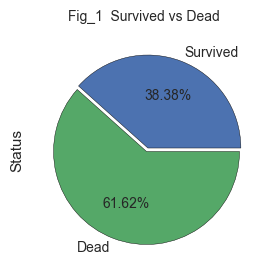

In [10]:
# Divide the information to survived group and dead group
df_survived = df_select [df_select['Survived'] == 1]
df_dead = df_select[df_select['Survived'] == 0]

print('\nBased on data, {} passengers survived this disaster and {} people were dead unfortunately.'
      .format(df_survived.shape[0], df_dead.shape[0]))

# draw the pie chart for "Survived vs Dead"
df_pie = pd.DataFrame([df_survived.shape[0], df_dead.shape[0]], index = ['Survived', 'Dead'], columns = ['Status'])
df_pie.plot(kind = 'pie', autopct = '%.2f%%', figsize = (3, 3), subplots = True, explode = (0.02,0.02),
            legend = False, title = 'Fig_1  Survived vs Dead')

In [11]:
# build a helper function to get groupby table
def group_table(by, df_survived = df_survived, df_dead = df_dead, rate = True, num = False):
    '''Generate a new dataframe based on Survived and Dead information and grouped as required
    
    by: str of a list of str used to groupby
    df_survived: survived data set, dataframe
    df_dead: dead data set, dataframe
    rate: choosing if adding rate column, boolean
    num: choosing if the rate column showing float number or percent by string, boolean
    output: dataframe'''
    
    survived_groupby = df_survived.groupby(by).count()
    dead_groupby = df_dead.groupby(by).count()
        
    #rename dead df column name
    dead_groupby.rename(columns = {'Survived': 'Dead'}, inplace = True)

    # merge data
    merged_df = pd.concat([survived_groupby[['Survived']], dead_groupby[['Dead']]], axis = 1)
    
    # Dealing with Nan data after merge
    merged_df_nonull = merged_df.fillna(0)
    
    if rate:
        # Adding the survival rate column
        merged_df_rate = survived_rate(merged_df_nonull, num = num)
        return merged_df_rate
    else:
        return merged_df_nonull
    
#  Build a function to calculate survival rate
def survived_rate(grouped_df, num = False):
    '''Caculate the survived rate and add that information into grouped dataframe
    
    grouped_df: dataframe
    num: choosing if the rate column showing float number or percent by string, boolean
    output: dataframe'''
    
    def rate_calculator(pd_series):
        ''' A helper funciotn to calucate the survived rate
        
        pd_series: a series with survvied and dead people number 
        output: a percent number in str'''
        
        rate = float(pd_series[0])/pd_series.sum() * 100
        rate_str = '{:0.2f}%'.format(rate)
        
        return rate_str
    
    def rate_calculator_num(pd_series):
        ''' A helper function to calucate the survived rate
        
        pd_series: a series with survived and dead people number
        output: a float number'''
        
        rate = float(pd_series[0]) / pd_series.sum()
        return rate.round(2)
    
    if not num:
        # calculate all the rates 
        rate_column = grouped_df.apply(rate_calculator, axis = 1)
    else:
        rate_column = grouped_df.apply(rate_calculator_num, axis = 1)
        
    rate_column.rename('Survival Rate', inplace = True)
    
    merged_df = pd.concat([grouped_df, rate_column], axis = 1)
    
    return merged_df

In [12]:
group_table('Sex')

,Survived,Dead,Survival Rate
Sex,,,
female,233,81,74.20%
male,109,468,18.89%


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000046C5E48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B742D68>], dtype=object)

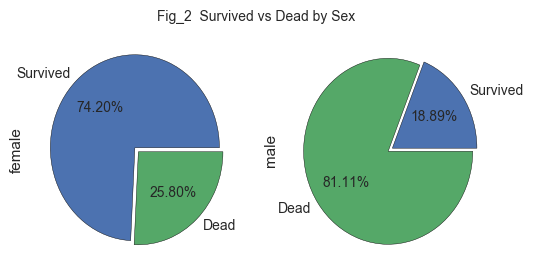

In [13]:
# Generate the data to draw a pie chart to compare
df_sex_pie = group_table('Sex')[['Survived', 'Dead']].transpose()

df_sex_pie.plot(kind = 'pie', explode = (0.03, 0.03), autopct = '%.2f%%', figsize = (6, 3), subplots = True,
                 legend = False, title = 'Fig_2  Survived vs Dead by Sex')

In [14]:
group_table('Age Group')

,Survived,Dead,Survival Rate
Age Group,,,
Children,40,29,57.97%
Teenager,39,56,41.05%
Adults,258,447,36.60%
Seniors,5,17,22.73%


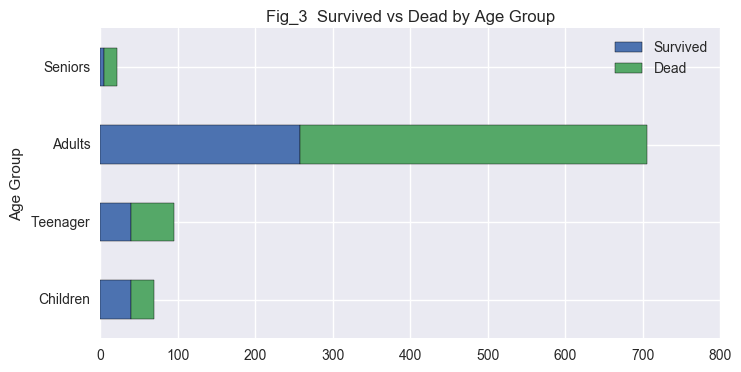

In [15]:
df_age_bar = group_table('Age Group')[['Survived', 'Dead']]
df_age_bar.plot(kind = 'barh', stacked = True, figsize = (8, 4), title = 'Fig_3  Survived vs Dead by Age Group')

### Answer to Q -1 : Did female and children have sigificant higher survival rates?

Well, according to Fig_2 and Fig_3, it is easily to find that __women indeed had a much higher survival rate__ (74% compared to man's poor 19%) and __children also enjoyed an obvious high rate__ as we expected. What's more, it seemed that senior group had the lowest survival rate.

In [16]:
#Considering the factor of sibling and spouse
group_table('SibSp')

,Survived,Dead,Survival Rate
SibSp,,,
0,210.0,398,34.54%
1,112.0,97,53.59%
2,13.0,15,46.43%
3,4.0,12,25.00%
4,3.0,15,16.67%
5,0.0,5,0.00%
8,0.0,7,0.00%


In [17]:
#Considering the factor of Parent and Child
group_table('Parch')

,Survived,Dead,Survival Rate
Parch,,,
0,233.0,445,34.37%
1,65.0,53,55.08%
2,40.0,40,50.00%
3,3.0,2,60.00%
4,0.0,4,0.00%
5,1.0,4,20.00%
6,0.0,1,0.00%


In [18]:
df_P_S = group_table(['Parch', 'SibSp'])
df_P_S.loc[0:2]

Survived   Dead Survival Rate
Parch SibSp                               
0     0         163.0  374.0        30.35%
      1          64.0   59.0        52.03%
      2           4.0   12.0        25.00%
      3           2.0    0.0       100.00%
1     0          25.0   13.0        65.79%
      1          34.0   23.0        59.65%
      2           6.0    1.0        85.71%
      3           0.0    7.0         0.00%
      4           0.0    9.0         0.00%
2     0          21.0    8.0        72.41%
      1          12.0    7.0        63.16%
      2           2.0    2.0        50.00%
      3           2.0    5.0        28.57%
      4           3.0    6.0        33.33%
      5           0.0    5.0         0.00%
      8           0.0    7.0         0.00%

### Answer to Q-2 :  Were people with families more likely to survive than the ones were alone on the ship? 

(SibSp refers to families like brothers, sisters and spouse; Parch refers to parents and children)

According to first two tables, it seems that people with 1 or 2 SibSp would have a higer survival rate than the ones without SibSp. And people with 1 or 2 Parch also were more likely to survive than people with 0 Parch. To be more specified, only __30.35% of the single passengers survived__ while __others with 1-3 families had much higer survival rates in general__ ( For example: people with 1 SibSp: 52.03% ; People with 1 Parch and 1 SibSp: 59.65%). 

When the family became bigger, the survival rate didn't go up but sharply dropped down in most cases. Considering the small sample numbers, the statistics shown here may include bias and more data is needed to do further analysis on big family situation.

In [19]:
# build a helper function to draw line charts 

def line_total_sex(factor, fig_num):
    '''Draw the line chart(male_only, female_only, total) of survival rate based on specified factor
    factor: str
    fig_num: fig_num used in the chart title, positive int'''
    
    # generate the total data for line chart 
    df_factor_n = group_table(factor, num = True)
    df_factor_line_t = df_factor_n['Survival Rate'].rename('Total', inplace = True)

    # generate the data for each gender
    df_sex_factor_n= group_table(['Sex',factor], num = True)
    df_factor_line_f = df_sex_factor_n.loc['female','Survival Rate'].rename('Female', inplace = True)
    df_factor_line_m = df_sex_factor_n.loc['male','Survival Rate'].rename('Male', inplace = True)

    # meger the data and draw the line chart
    df_factor_line = pd.concat([df_factor_line_t, df_factor_line_f, df_factor_line_m], axis = 1)
    df_factor_line.plot(color = ['g','r','b'], marker = 'o', figsize = (5, 3),
                        title = 'Fig_{}  Survival Rate by {}'.format(fig_num, factor))

In [20]:
group_table('Pclass')

,Survived,Dead,Survival Rate
Pclass,,,
1,136,80,62.96%
2,87,97,47.28%
3,119,372,24.24%


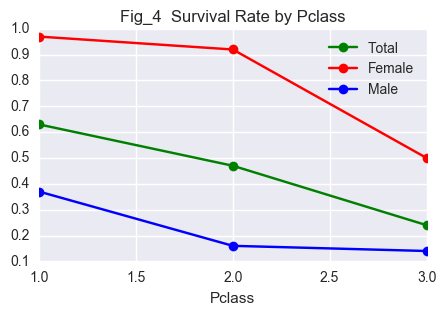

In [21]:
line_total_sex('Pclass',4)

In [22]:
group_table('Fare Group')

,Survived,Dead,Survival Rate
Fare Group,,,
0 to 8,51,175,22.57%
08 to 15,62,155,28.57%
15 to 31,99,112,46.92%
over 31,129,93,58.11%


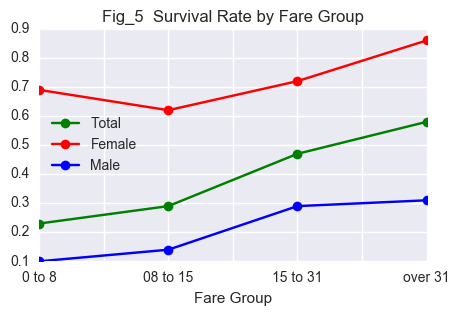

In [23]:
line_total_sex('Fare Group', 5)

### Answer to Q -3 : Were the richer people (depending on the fare paid and their Pclass level) more likely to survive ?

(1 is the highest Pcalss level)

Based on grouped table data, __higher Pclass level people trend to have a higher survival rate__. 

Is that beacuse most females were in Pclass level -1 (since female had a much higher servival rate)? From line chart Fig_4 , all three lines dropped down with the decreasing of Pclass level so the assumption is valid no matter taking gender factor into consideration or not.

Judging by numbers, the fare group data showed same tendency: __people who paid higher fares seemed to be more likely to survive__. 

However, when I include the gender factor, the line chart looks a little different: female passengers who paid 0-8 had a slightly higher survival rate than the ones paid 8 to 15. In fact, the three female fare groups had a similiar high survival rate compared to male. _"Lady first" really worked at that time even than money did._

Therefore, it seems that __richer people would have a better chance to survive this disaster__ in general.

## ------ Hyperthesis Test

Since survival status and other factors studied above are all categorical data, I choose Chi Square test to check the correlation between them.

I choose alpha = 0.05 and H0 / Ha for each factor as below:
- For gender, H0: Sex and survival status are independent; Ha: Sex and survival status are dependent

- For Pclass, H0: Pclass and survival status are independent; Ha: Pclass and survival status are dependent

- For age group, H0: age group and survival status are independent; Ha: age group and survival status are dependent

- For fare group, H0: fare group and survial status are independent; Ha: fare group and survial status are dependent

- For SibSp, H0: SibSp and survial status are independent; Ha: SibSp and survial status are dependent

- For Parch, H0: Parch and survial status are independent; Ha: Parch and survial status are dependent

In [24]:
import scipy.stats as ss
# definde a function to calculate the P value of Chi square test 
def chi2_test_Pvalue(factor):
    '''Return the P value of chi square test between factor and survival status
    factor: string
    return: float'''
    
    contingency_table = group_table(factor, rate = False)
    chi2_result = ss.chi2_contingency(contingency_table.values) ## reference 4
    
    print('\nThe P value of Chi Square test between {} and Survival Status is: {:.4f}'.format(factor, chi2_result[1]))

In [25]:
chi2_test_Pvalue('Sex')
chi2_test_Pvalue('Pclass')
chi2_test_Pvalue('Age Group')
chi2_test_Pvalue('Fare Group')
chi2_test_Pvalue('Parch')
chi2_test_Pvalue('SibSp')


The P value of Chi Square test between Sex and Survival Status is: 0.0000

The P value of Chi Square test between Pclass and Survival Status is: 0.0000

The P value of Chi Square test between Age Group and Survival Status is: 0.0021

The P value of Chi Square test between Fare Group and Survival Status is: 0.0000

The P value of Chi Square test between Parch and Survival Status is: 0.0001

The P value of Chi Square test between SibSp and Survival Status is: 0.0000


All the P value is less than our alpha 0.05 so reject all H0 hyperthesis:   
   
"Sex","Pclass", "Age", "Fare", "SibSp", and "Parch" are __dependent__ with "Survival Stutas" in Titanic's disaster based on the data provided.

## Quick Conclusion:

Based on provided data, female, children, richer people (higher Pclass level and paying higher fare), people with 1-3 famlies on the ship were more likely to survive the Titanic Disaster than others.

#### Report Limitation to be noticed:
1. The provied data is only part of the whole population. No information about how the samples were collected and selected is given, so sampling itself may include bias already.
2. When cleaning the data, I used estimated values to apprach the missing data. For example, I used mean value (rounded to 30) in Age columns assuming the missing data had similar distribution. If the missing data was not in fact, big bias may be introduced into my analysis.  
